# Simple Baseline Method of 2D Keypoint Estimation

## Imports and Setup

In [47]:
import os
import src.bug_dataset
from src.models.pose_resnet import BasicBlock, PoseResNet, Bottleneck
from src.train_simple_2d_network import Train_simple_2d_Network
import numpy as np
import pandas as pd
from skimage import io
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [2]:
target_dir = "../data/single_sungaya/"
out_df = pd.read_hdf(os.path.join(target_dir, "Data_3D_Pose.hdf5"))

In [3]:
reduceKeypoints = True
sungaya_dataset = src.bug_dataset.BugDataset(df=out_df,reduced=reduceKeypoints,
                             root_dir=target_dir,transform=transforms.Compose([
                                src.bug_dataset.ToTensor()
                                   ]))

In [4]:
batch_size = 32

train_split = 0.7
valid_split = 0.1
train_size = int(train_split * len(sungaya_dataset))
valid_size = int(valid_split * len(sungaya_dataset))
test_size = len(sungaya_dataset) - (train_size+valid_size)

train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(sungaya_dataset, [train_size, valid_size, test_size], 
                                                                          generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
# Create Model
num_layers = 18
resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}
if reduceKeypoints:
    block_class, layers = resnet_spec[num_layers]
    model = PoseResNet(block_class, layers, 28)

else:
    block_class, layers = resnet_spec[num_layers]
    model = PoseResNet(block_class, layers, 62)

In [6]:
load = False
if load == True:
    path = "..\model\estimator2d.pt"
    model.load_state_dict(torch.load(path))
    model.eval()

epochs = 140
learning_rate = 2e-4  #-6
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
liftingtrainer = Train_simple_2d_Network(model,optimizer, train_dataloader, valid_dataloader)
trained_model = liftingtrainer.run(epochs)

Using cuda device


Simple 2D Model Epochs:   0%|          | 0/140 [00:00<?, ?it/s]

Finished Epoch 001: | Train Acc: 0.007 | Train Loss: 0.00479 | Val Acc: 0.006 | Val Loss: 0.00437
Finished Epoch 002: | Train Acc: 0.007 | Train Loss: 0.00139 | Val Acc: 0.006 | Val Loss: 0.00124
Finished Epoch 003: | Train Acc: 0.007 | Train Loss: 0.00136 | Val Acc: 0.009 | Val Loss: 0.00314
Finished Epoch 004: | Train Acc: 0.008 | Train Loss: 0.00129 | Val Acc: 0.010 | Val Loss: 0.00142
Finished Epoch 005: | Train Acc: 0.010 | Train Loss: 0.00130 | Val Acc: 0.011 | Val Loss: 0.00124
Finished Epoch 006: | Train Acc: 0.014 | Train Loss: 0.00127 | Val Acc: 0.018 | Val Loss: 0.00136
Finished Epoch 007: | Train Acc: 0.024 | Train Loss: 0.00126 | Val Acc: 0.023 | Val Loss: 0.00124
Finished Epoch 008: | Train Acc: 0.029 | Train Loss: 0.00125 | Val Acc: 0.030 | Val Loss: 0.00122
Finished Epoch 009: | Train Acc: 0.032 | Train Loss: 0.00122 | Val Acc: 0.033 | Val Loss: 0.00150
Finished Epoch 010: | Train Acc: 0.040 | Train Loss: 0.00125 | Val Acc: 0.043 | Val Loss: 0.00155
Finished Epoch 011: 

In [12]:
trained_model = liftingtrainer.model
trained_model.eval()
# Code get the first batch of results
with torch.no_grad():
    for data in test_dataloader:
        image = data['image']
        target = data['heatmap']
        file_name = data['file_name']
        kp = data['key_points_2D']
        visib = data['visibility']
        input_var = image.to(liftingtrainer.device, dtype=torch.float)
        heatmap_var = target.to(liftingtrainer.device, dtype=torch.float)

        predi = trained_model(input_var)
        break

Limb Visible 1 [159  61]


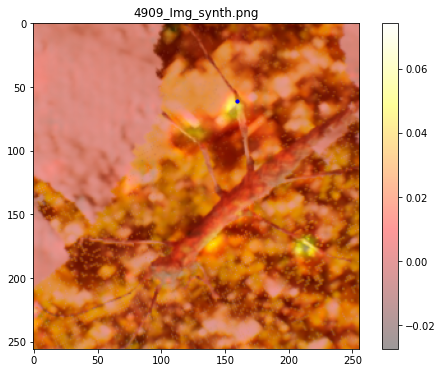

In [85]:
import cv2
from src.eval.accuracies import get_max_preds
# Display a sample
sample = 31
limb = 11

name = file_name[sample]

img = image[sample].numpy()
img=np.swapaxes(img,0,1)
img=np.swapaxes(img,1,2)

pred = predi.cpu().numpy()
pred_kp, _ = get_max_preds(pred)

acc = target.cpu().numpy()
acc_kp = ((kp[sample].numpy()*sungaya_dataset.std_2d)+sungaya_dataset.means_2d).astype(int)

vis = visib[sample].cpu().numpy()
print("Limb Visible", vis[limb] , acc_kp[limb])
plt.figure(figsize=(8,6))
plt.imshow(img)

# plt.scatter(pred_kp[sample,:,0], pred_kp[sample,:,1], marker='o', s=10,  color='r')
plt.scatter(acc_kp[limb,0], acc_kp[limb,1], marker='o', s=10,  color='b')

plt.imshow(cv2.resize(pred[sample,limb], (256,256)), alpha = .4,cmap='hot')
# plt.imshow(cv2.resize(acc[sample,limb], (256,256)), alpha = .5,cmap='hot')

plt.colorbar()
plt.title(name)
plt.show()

In [42]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# PATH = "..\models\simple_2d_overfitted.pt"
# torch.save(trained_model.state_dict(), PATH)

In [49]:
# Display recent training loss graph
file_path = '..\\results\simple_2d_model_20220309-163201_train_loss.txt'
losses = []
with open(file_path) as file:
    losses = [float(line.rstrip()) for line in file]

epochs = list(range(1,len(losses)+1))

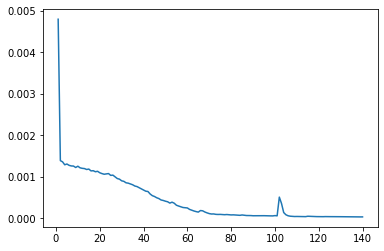

In [50]:
plt.figure() 
plt.plot(epochs,losses)
plt.show()
